In [48]:
import pandas as pd
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split
import matplotlib.pyplot  as plt
import numpy as np
import pmdarima as pm
from pmdarima.arima import ARIMA
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import datetime
import requests
import warnings
import matplotlib
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")

df = pd.read_csv('multivariate_eng_df.csv', index_col = 'Date', parse_dates = True).drop(columns = 'Unnamed: 0')
df.head()

,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,Series_Complete_5Plus,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [49]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

In [50]:
#separate univariate dataframe for california
ca_uni_df = ca_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT']]

In [51]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

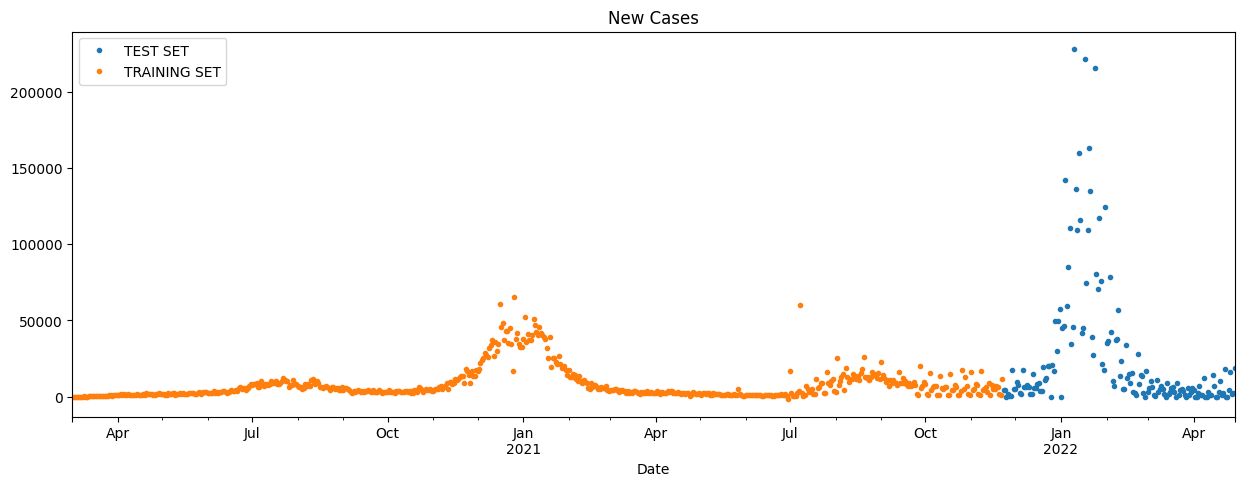

In [52]:
#visualize the 80/20 train/test split
ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer')

_ = ca_uni_test \
    .rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TEST SET'}) \
    .join(ca_uni_train.rename(columns={'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='New Cases', style='.')

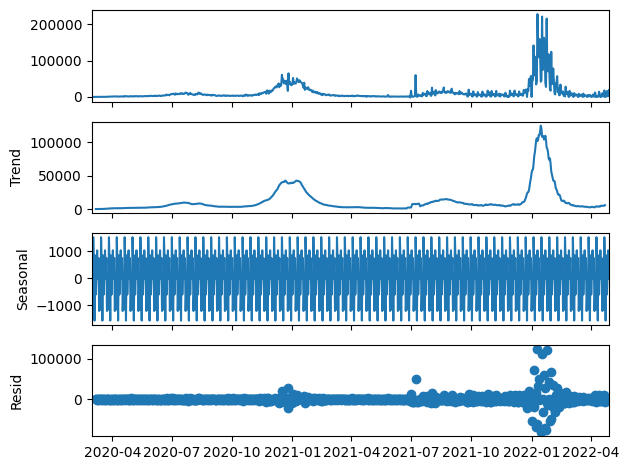

In [53]:
#time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
seasonal_decompose(ca_uni_df, period=12).plot()

plt.show()

In [54]:
#baseline seasonal arima model
import statsmodels.api as sm

sarimax = sm.tsa.statespace.SARIMAX(ca_uni_train, order = (1, 1, 1),seasonal_order=(1,1,1,12))
seasonal_model = sarimax.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90643D+00    |proj g|=  2.64699D-01


 This problem is unconstrained.



At iterate    5    f=  9.74693D+00    |proj g|=  5.27818D-02

At iterate   10    f=  9.73668D+00    |proj g|=  1.96805D-02

At iterate   15    f=  9.73378D+00    |proj g|=  4.67070D-04

At iterate   20    f=  9.73377D+00    |proj g|=  5.21888D-04

At iterate   25    f=  9.73354D+00    |proj g|=  8.59827D-03

At iterate   30    f=  9.70992D+00    |proj g|=  9.52303D-02

At iterate   35    f=  9.64187D+00    |proj g|=  5.78820D-03

At iterate   40    f=  9.64184D+00    |proj g|=  7.18008D-04

At iterate   45    f=  9.64170D+00    |proj g|=  3.98825D-03

At iterate   50    f=  9.64163D+00    |proj g|=  7.54534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

<Axes: xlabel='Date'>

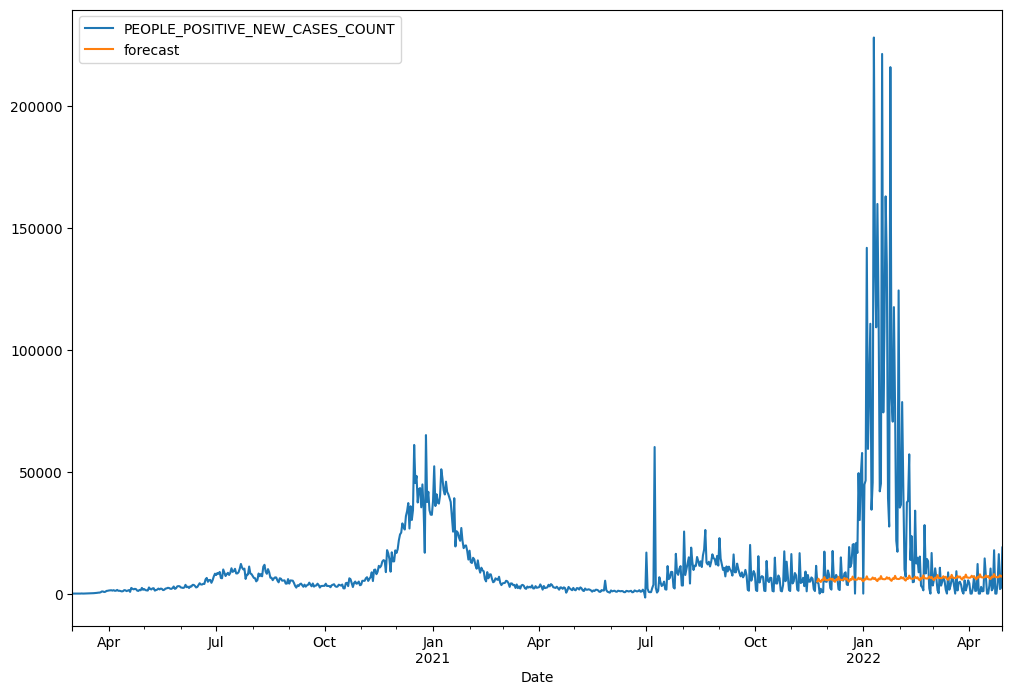

In [55]:
ca_uni_df['forecast']=seasonal_model.predict(start=632,end=790,dynamic=True)
ca_uni_df[['PEOPLE_POSITIVE_NEW_CASES_COUNT','forecast']].plot(figsize=(12,8))

In [56]:
#identification -- determine values of p & q
#use gridsearch to select values of p and q -- AIC performance metric
warnings.filterwarnings("ignore")
results=[]
for p in range(1,3):
    for q in range(1,3):
        for P in range(1,3):
            for Q in range(1,3):
                print(p,q,P,Q)
                model=sm.tsa.statespace.SARIMAX(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(p,1,q), seasonal_order=(P,1,Q,12)).fit()
                results.append([p,q,P,Q,model.aic])  
                
# Create a DataFrame from the results
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic') 

1 1 1 1
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90643D+00    |proj g|=  2.64699D-01

At iterate    5    f=  9.74693D+00    |proj g|=  5.27818D-02

At iterate   10    f=  9.73668D+00    |proj g|=  1.96805D-02

At iterate   15    f=  9.73378D+00    |proj g|=  4.67070D-04

At iterate   20    f=  9.73377D+00    |proj g|=  5.21888D-04

At iterate   25    f=  9.73354D+00    |proj g|=  8.59827D-03

At iterate   30    f=  9.70992D+00    |proj g|=  9.52303D-02

At iterate   35    f=  9.64187D+00    |proj g|=  5.78820D-03

At iterate   40    f=  9.64184D+00    |proj g|=  7.18008D-04

At iterate   45    f=  9.64170D+00    |proj g|=  3.98825D-03

At iterate   50    f=  9.64163D+00    |proj g|=  7.54534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates 

 This problem is unconstrained.



At iterate    5    f=  9.73844D+00    |proj g|=  3.65570D-02

At iterate   10    f=  9.73368D+00    |proj g|=  1.60722D-03

At iterate   15    f=  9.73360D+00    |proj g|=  3.11436D-03

At iterate   20    f=  9.73348D+00    |proj g|=  2.14606D-04

At iterate   25    f=  9.73348D+00    |proj g|=  2.09435D-04

At iterate   30    f=  9.73341D+00    |proj g|=  5.97204D-03

At iterate   35    f=  9.68784D+00    |proj g|=  1.22090D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     64      1     0     0   7.587D-02   9.647D+00
  F =   9.6466901660915081     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


1 1 2 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91953D+00    |proj g|=  3.06016D-01


 This problem is unconstrained.



At iterate    5    f=  9.82305D+00    |proj g|=  1.74300D-01

At iterate   10    f=  9.75835D+00    |proj g|=  3.90184D-02

At iterate   15    f=  9.73315D+00    |proj g|=  5.38140D-03

At iterate   20    f=  9.73256D+00    |proj g|=  1.09581D-04

At iterate   25    f=  9.73256D+00    |proj g|=  6.85514D-04

At iterate   30    f=  9.73244D+00    |proj g|=  9.24330D-03

At iterate   35    f=  9.71828D+00    |proj g|=  1.08957D-01

At iterate   40    f=  9.64120D+00    |proj g|=  5.36208D-03

At iterate   45    f=  9.64047D+00    |proj g|=  3.51784D-03

At iterate   50    f=  9.63996D+00    |proj g|=  1.69506D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92287D+00    |proj g|=  3.60923D-01

At iterate    5    f=  9.74986D+00    |proj g|=  1.07507D-01

At iterate   10    f=  9.73381D+00    |proj g|=  1.56207D-03

At iterate   15    f=  9.73372D+00    |proj g|=  1.70892D-04

At iterate   20    f=  9.73367D+00    |proj g|=  3.32555D-03

At iterate   25    f=  9.73267D+00    |proj g|=  3.13539D-03

At iterate   30    f=  9.73248D+00    |proj g|=  6.20753D-04

At iterate   35    f=  9.73248D+00    |proj g|=  7.59167D-05

At iterate   40    f=  9.73246D+00    |proj g|=  2.20611D-03

At iterate   45    f=  9.73004D+00    |proj g|=  1.99214D-02

At iterate   50    f=  9.64751D+00    |proj g|=  3.67247D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates 

 This problem is unconstrained.



At iterate    5    f=  9.76154D+00    |proj g|=  4.55393D-02

At iterate   10    f=  9.75126D+00    |proj g|=  4.51065D-03

At iterate   15    f=  9.74632D+00    |proj g|=  3.73262D-03

At iterate   20    f=  9.74360D+00    |proj g|=  1.64964D-03

At iterate   25    f=  9.74350D+00    |proj g|=  9.00018D-05

At iterate   30    f=  9.74348D+00    |proj g|=  1.21687D-03

At iterate   35    f=  9.74184D+00    |proj g|=  1.50692D-02

At iterate   40    f=  9.68940D+00    |proj g|=  6.25866D-02

At iterate   45    f=  9.62323D+00    |proj g|=  4.44970D-03

At iterate   50    f=  9.62300D+00    |proj g|=  1.58216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.75268D+00    |proj g|=  8.03612D-03

At iterate   10    f=  9.75116D+00    |proj g|=  1.00321D-02

At iterate   15    f=  9.74617D+00    |proj g|=  3.71625D-03

At iterate   20    f=  9.74297D+00    |proj g|=  1.13899D-03

At iterate   25    f=  9.74286D+00    |proj g|=  4.97678D-04

At iterate   30    f=  9.74281D+00    |proj g|=  1.10292D-04

At iterate   35    f=  9.74281D+00    |proj g|=  4.37069D-04

At iterate   40    f=  9.74144D+00    |proj g|=  7.94611D-03

At iterate   45    f=  9.66640D+00    |proj g|=  2.03099D-02

At iterate   50    f=  9.64505D+00    |proj g|=  6.77552D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.78966D+00    |proj g|=  4.84074D-02

At iterate   10    f=  9.76006D+00    |proj g|=  3.09817D-02

At iterate   15    f=  9.74922D+00    |proj g|=  4.75713D-03

At iterate   20    f=  9.74598D+00    |proj g|=  5.09141D-03

At iterate   25    f=  9.74504D+00    |proj g|=  4.72524D-03

At iterate   30    f=  9.74251D+00    |proj g|=  2.02700D-04

At iterate   35    f=  9.74251D+00    |proj g|=  1.83485D-04

At iterate   40    f=  9.74227D+00    |proj g|=  2.44124D-03

At iterate   45    f=  9.74223D+00    |proj g|=  9.38330D-05

At iterate   50    f=  9.74221D+00    |proj g|=  1.31979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81336D+00    |proj g|=  1.27249D-01

At iterate    5    f=  9.75446D+00    |proj g|=  2.79107D-02

At iterate   10    f=  9.75198D+00    |proj g|=  3.11972D-03

At iterate   15    f=  9.74646D+00    |proj g|=  1.31385D-02

At iterate   20    f=  9.74314D+00    |proj g|=  1.37882D-03

At iterate   25    f=  9.74269D+00    |proj g|=  2.05422D-03

At iterate   30    f=  9.74243D+00    |proj g|=  4.98643D-04

At iterate   35    f=  9.74223D+00    |proj g|=  2.28952D-03

At iterate   40    f=  9.74221D+00    |proj g|=  1.55133D-04

At iterate   45    f=  9.74221D+00    |proj g|=  1.79608D-04

At iterate   50    f=  9.74215D+00    |proj g|=  5.46236D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.73127D+00    |proj g|=  1.77546D-02

At iterate   10    f=  9.72451D+00    |proj g|=  3.75989D-03

At iterate   15    f=  9.72448D+00    |proj g|=  7.56065D-05

At iterate   20    f=  9.72447D+00    |proj g|=  1.11023D-03

At iterate   25    f=  9.72356D+00    |proj g|=  1.26893D-02

At iterate   30    f=  9.69145D+00    |proj g|=  5.91173D-02

At iterate   35    f=  9.63681D+00    |proj g|=  3.15512D-02

At iterate   40    f=  9.63563D+00    |proj g|=  1.29527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     45      1     0     0   7.670D-07   9.636D+00
  F =   9.63562692925

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74468D+00    |proj g|=  5.46565D-02

At iterate    5    f=  9.72474D+00    |proj g|=  6.55967D-03

At iterate   10    f=  9.72446D+00    |proj g|=  1.24770D-04

At iterate   15    f=  9.72445D+00    |proj g|=  1.37748D-03

At iterate   20    f=  9.72439D+00    |proj g|=  7.35267D-04

At iterate   25    f=  9.72437D+00    |proj g|=  3.21723D-04

At iterate   30    f=  9.72437D+00    |proj g|=  9.81900D-04

At iterate   35    f=  9.72384D+00    |proj g|=  1.19564D-02

At iterate   40    f=  9.69629D+00    |proj g|=  7.18477D-02

At iterate   45    f=  9.63542D+00    |proj g|=  5.06390D-02

At iterate   50    f=  9.63247D+00    |proj g|=  6.96129D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.76431D+00    |proj g|=  8.42565D-02

At iterate   10    f=  9.72783D+00    |proj g|=  2.17681D-02

At iterate   15    f=  9.72378D+00    |proj g|=  6.63139D-03

At iterate   20    f=  9.72345D+00    |proj g|=  7.57494D-05

At iterate   25    f=  9.72345D+00    |proj g|=  6.90900D-04

At iterate   30    f=  9.72311D+00    |proj g|=  8.31167D-03

At iterate   35    f=  9.65160D+00    |proj g|=  7.22923D-02

At iterate   40    f=  9.63433D+00    |proj g|=  1.16860D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     50      1     0     0   9.330D-06   9.634D+00
  F =   9.63419984882

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76813D+00    |proj g|=  7.77605D-02

At iterate    5    f=  9.72509D+00    |proj g|=  5.60532D-03

At iterate   10    f=  9.72435D+00    |proj g|=  1.89526D-04

At iterate   15    f=  9.72422D+00    |proj g|=  1.15995D-02

At iterate   20    f=  9.72356D+00    |proj g|=  5.39406D-03

At iterate   25    f=  9.72339D+00    |proj g|=  2.40850D-03

At iterate   30    f=  9.72336D+00    |proj g|=  7.57828D-05

At iterate   35    f=  9.72336D+00    |proj g|=  9.02125D-04

At iterate   40    f=  9.72283D+00    |proj g|=  7.51932D-03

At iterate   45    f=  9.68336D+00    |proj g|=  7.63647D-02

At iterate   50    f=  9.63482D+00    |proj g|=  9.00803D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.74062D+00    |proj g|=  2.72558D-02

At iterate   10    f=  9.73535D+00    |proj g|=  2.26712D-03

At iterate   15    f=  9.73216D+00    |proj g|=  1.41759D-02

At iterate   20    f=  9.72906D+00    |proj g|=  5.82844D-03

At iterate   25    f=  9.72893D+00    |proj g|=  2.62916D-03

At iterate   30    f=  9.72889D+00    |proj g|=  7.92337D-05

At iterate   35    f=  9.72889D+00    |proj g|=  1.14503D-03

At iterate   40    f=  9.72868D+00    |proj g|=  1.02833D-02

At iterate   45    f=  9.70336D+00    |proj g|=  5.96940D-02

At iterate   50    f=  9.63817D+00    |proj g|=  3.69752D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.73582D+00    |proj g|=  6.80233D-03

At iterate   10    f=  9.73537D+00    |proj g|=  3.15008D-03

At iterate   15    f=  9.73042D+00    |proj g|=  1.95452D-02

At iterate   20    f=  9.72850D+00    |proj g|=  2.10371D-03

At iterate   25    f=  9.72838D+00    |proj g|=  4.90009D-03

At iterate   30    f=  9.72825D+00    |proj g|=  1.25854D-03

At iterate   35    f=  9.72822D+00    |proj g|=  1.80023D-04

At iterate   40    f=  9.72821D+00    |proj g|=  7.68218D-04

At iterate   45    f=  9.72793D+00    |proj g|=  3.81842D-03

At iterate   50    f=  9.72021D+00    |proj g|=  3.43369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.77408D+00    |proj g|=  5.05311D-02

At iterate   10    f=  9.73840D+00    |proj g|=  2.19382D-02

At iterate   15    f=  9.73409D+00    |proj g|=  1.62770D-03

At iterate   20    f=  9.73115D+00    |proj g|=  2.06564D-02

At iterate   25    f=  9.72802D+00    |proj g|=  8.85960D-03

At iterate   30    f=  9.72765D+00    |proj g|=  7.08533D-04

At iterate   35    f=  9.72763D+00    |proj g|=  1.29373D-04

At iterate   40    f=  9.72760D+00    |proj g|=  3.05416D-03

At iterate   45    f=  9.72430D+00    |proj g|=  2.17973D-02

At iterate   50    f=  9.70319D+00    |proj g|=  8.25360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  9.73765D+00    |proj g|=  1.98617D-02

At iterate   10    f=  9.73535D+00    |proj g|=  4.72950D-03

At iterate   15    f=  9.73166D+00    |proj g|=  3.50652D-02

At iterate   20    f=  9.72856D+00    |proj g|=  7.62115D-03

At iterate   25    f=  9.72834D+00    |proj g|=  1.11325D-03

At iterate   30    f=  9.72798D+00    |proj g|=  1.94769D-03

At iterate   35    f=  9.72775D+00    |proj g|=  8.40389D-04

At iterate   40    f=  9.72770D+00    |proj g|=  1.78950D-04

At iterate   45    f=  9.72768D+00    |proj g|=  3.78013D-04

At iterate   50    f=  9.72768D+00    |proj g|=  7.93808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

In [57]:
df_results

,p,q,P,Q,aic
4,1,2,1,1,12175.476431
9,2,1,1,2,12189.447678
8,2,1,1,1,12191.432439
10,2,1,2,1,12191.628609
11,2,1,2,2,12194.417016
12,2,2,1,1,12196.649968
2,1,1,2,1,12196.911482
0,1,1,1,1,12197.024817
5,1,2,1,2,12205.342821
1,1,1,1,2,12205.416370


In [58]:
#optimal SARIMA model revealed via gridsearch with AIC for performance evaluation
#train model
sarimax_1=sm.tsa.statespace.SARIMAX(ca_uni_train['PEOPLE_POSITIVE_NEW_CASES_COUNT'],order=(1,1,2), seasonal_order=(1,1,1,12)).fit()

#make predictions
predictions_1 = sarimax_1.predict(start=632,end=789,dynamic=True)

#calculate performance metrics
mae = mean_absolute_error(ca_uni_test, predictions_1)
mse = mean_squared_error(ca_uni_test, predictions_1)
rmse = np.sqrt(mse)
#calculate mape adding a small number to avoid division by zero
predictions_array = np.array(predictions_1)
ca_uni_test_array = np.array(ca_uni_test)
absolute_percent_error = np.where(ca_uni_test_array != 0, np.abs((ca_uni_test_array - predictions_array) / ca_uni_test_array), np.nan)
valid_ape = absolute_percent_error[~np.isnan(absolute_percent_error)]
mape = np.mean(valid_ape) * 100

#naive forecast for mase calculation
naive_forecast = ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = mae / mae_naive

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Percent Error: {mape}')
print(f'Mean Absolute Scaled Error: {mase}')

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82455D+00    |proj g|=  1.03291D-01

At iterate    5    f=  9.76154D+00    |proj g|=  4.55393D-02

At iterate   10    f=  9.75126D+00    |proj g|=  4.51065D-03

At iterate   15    f=  9.74632D+00    |proj g|=  3.73262D-03

At iterate   20    f=  9.74360D+00    |proj g|=  1.64964D-03

At iterate   25    f=  9.74350D+00    |proj g|=  9.00018D-05

At iterate   30    f=  9.74348D+00    |proj g|=  1.21687D-03

At iterate   35    f=  9.74184D+00    |proj g|=  1.50692D-02

At iterate   40    f=  9.68940D+00    |proj g|=  6.25866D-02

At iterate   45    f=  9.62323D+00    |proj g|=  4.44970D-03

At iterate   50    f=  9.62300D+00    |proj g|=  1.58216D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau